In [1]:
from custom import MammoCLIP, MammoCLIPConfig, MammogramDataset, Config, MammogramPreprocessor, MammogramTransform
from transformers import BertTokenizerFast
from utils import evaluate_birads
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
cfg = Config.from_yaml("./mammoclip-v1/config.yaml")

In [5]:
model = MammoCLIP.from_pretrained("./mammoclip-v1/model_030")

You are using a model of type mammo_clip to instantiate a model of type vision-text-dual-encoder. This is not supported for all configurations of models and can yield errors.


In [3]:
cfg

Config:
  project_dir: ./mammoclip-v1
  seed: 42
  csv_path: ./data/complete-mammo.csv
  freeze_vision_model: True
  freeze_text_model: True
  training_params:
    num_epochs: 300
    train_fraction: 0.8
    batch_size: 256
    lr_max: 0.0001
    lr_min: 5e-07
    lr_scheduler: wsd_schedule
    warmup_fraction: 0.05
    steady_fraction: 0.25
    gradient_accumulation_steps: 1
    max_grad_norm: 1.0
    weight_decay: 1e-06
    mixed_precision: bf16
  dl_workers:
    train: 2
    val: 2
  train_ds:
    class_: MammogramDataset
    attrs_:
      alt_text_cols:
        - aug_report
      alt_text_prob: 0.5
      cache_dir: .cache
      image_cols:
        - r_cc
        - l_cc
        - r_mlo
        - l_mlo
      image_preprocessor:
        attrs_:
          extract_largest_cc: True
          output_size:
            - 518
            - 518
          use_clahe: True
        class_: MammogramPreprocessor
      path_to_df: ./mammoclip-v1/train.csv
      pid_col: id
      text_col: report
  

In [5]:
dataset = MammogramDataset(
    pid_col="id",
    text_col="report",
    cache_dir="./.cache",
    image_cols=["r_cc", "l_cc", "r_mlo", "l_mlo"],
    image_preprocessor=MammogramPreprocessor(**ds_cfg["attrs_"]["image_preprocessor"]["attrs_"]),
    transform_function=MammogramTransform(**ds_cfg["attrs_"]["transform_function"]["attrs_"]),
    df=pd.read_csv("./data/complete-mammo.csv").iloc[0:5000],
    tokenizer=BertTokenizerFast.from_pretrained("microsoft/BiomedVLP-CXR-BERT-general"),
    tokenizer_kwargs={'max_length': 256,
   'padding': 'max_length',
   'return_tensors': 'pt',
   'truncation': True},
)

In [6]:
results = evaluate_birads(
    model=model.cuda().eval(),
    dataset=dataset,
    batch_size=64,
    device="cuda",
)

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

In [7]:
results.keys()

dict_keys(['accuracy', 'precision', 'recall', 'f1', 'confusion_matrix'])

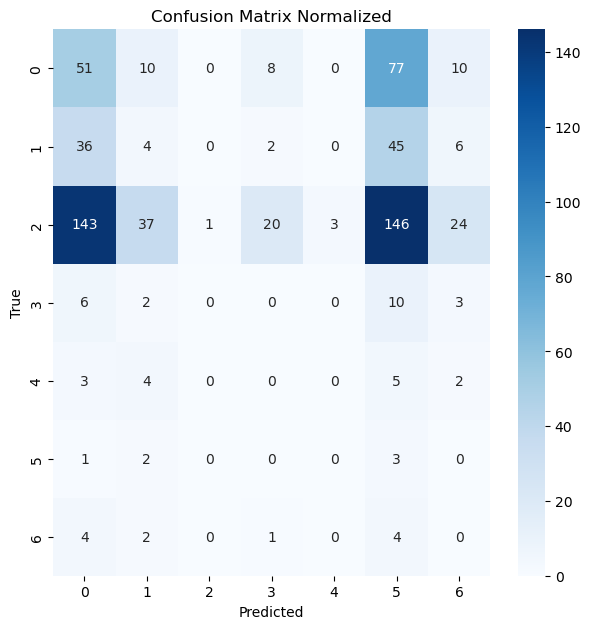

In [15]:
# plot the cm
cm = results["confusion_matrix"]
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')
plt.tight_layout()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Normalized")
plt.show()